In [15]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


import os
import yaml
import argparse
import numpy as np
from pathlib import Path
from models import *
from experiment import VAEXperiment
import torch.backends.cudnn as cudnn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from dataset import VAEDataset
from pytorch_lightning.plugins import DDPPlugin

import matplotlib.pyplot as plt

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [28]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
        
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

    
    
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of feature maps in discriminator
ndf = 64

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")



# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)  

PATH="../../GANModels/netD1.p"

netD.load_state_dict(torch.load(PATH,map_location=torch.device(device)))


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


<All keys matched successfully>

In [14]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))


In [26]:
#   size using a transformer.
image_size = 64
# Batch size during training
batch_size = 128

# Number of workers for dataloader
workers = 2


dataroot="../PyTorch-VAE/logs/ConditionalVAE/artificial/"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


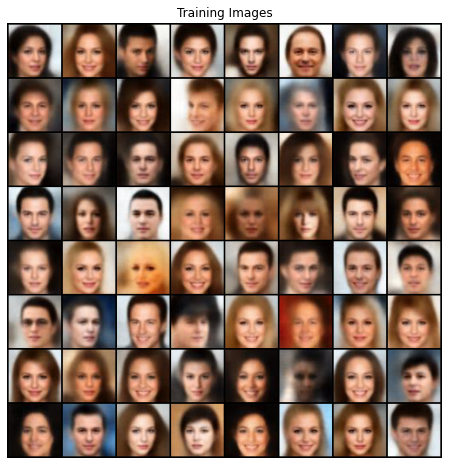

In [36]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [33]:
D_losses=[]
with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
        real_cpu = data[0].to(device)
        print(real_cpu.shape)
        output = netD(real_cpu).view(-1)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        print(output)
        errD_real = criterion(output, label)
        errD = errD_real
        D_losses.append(errD.item())

torch.Size([128, 3, 64, 64])
tensor([0.0117, 0.0047, 0.0031, 0.0035, 0.0011, 0.0160, 0.0113, 0.0006, 0.0051,
        0.0008, 0.0099, 0.0014, 0.0037, 0.0591, 0.0087, 0.0009, 0.0041, 0.0008,
        0.0095, 0.0046, 0.0031, 0.0039, 0.0135, 0.0011, 0.0060, 0.0010, 0.0192,
        0.0047, 0.0037, 0.0006, 0.0034, 0.0129, 0.0014, 0.0040, 0.0118, 0.0263,
        0.0054, 0.0010, 0.0008, 0.0013, 0.0002, 0.0096, 0.0045, 0.0030, 0.0232,
        0.0105, 0.0146, 0.0045, 0.0028, 0.0050, 0.0130, 0.0092, 0.0004, 0.0082,
        0.0014, 0.0009, 0.0019, 0.0010, 0.0053, 0.0041, 0.0004, 0.0049, 0.0115,
        0.0053, 0.0092, 0.0017, 0.0052, 0.0024, 0.0010, 0.0078, 0.0206, 0.0007,
        0.0008, 0.0069, 0.0006, 0.0013, 0.0040, 0.0254, 0.0194, 0.0101, 0.0008,
        0.0031, 0.0035, 0.0011, 0.0079, 0.0013, 0.0025, 0.0162, 0.0068, 0.0052,
        0.0167, 0.0058, 0.0011, 0.0009, 0.0041, 0.0044, 0.0027, 0.0049, 0.0039,
        0.0090, 0.0109, 0.0260, 0.0533, 0.0119, 0.0061, 0.0027, 0.0009, 0.0045,
        0.0

In [37]:
D_losses

[5.553341388702393,
 5.6432905197143555,
 5.732557773590088,
 5.548372268676758,
 5.403610706329346,
 5.750525951385498,
 5.562677383422852,
 5.562302112579346]

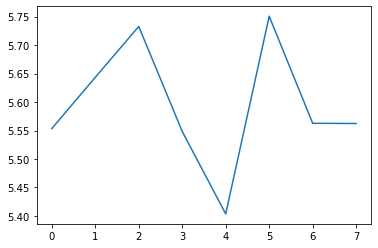

In [38]:
plt.plot(D_losses)